In [1]:
# 方程式を定義
import numpy as np
import math
import functools
from scipy import integrate

def func_r(q, b):
    value = q / (1 - b + b * q) / (1 - b + b * q)
    return value

def func_f_integrand(z, m, q, a, b):
    return math.exp(-z**2/2) * np.tanh(b * (m + math.sqrt(a * func_r(q, b)) * z))

def func_f(m, q, a, b):
    func  = functools.partial(func_f_integrand, m=m, q=q, a=a, b=b)
    return m - (1 / math.sqrt(2 * np.pi)) * integrate.quad(func, -10.0, 10.0)[0]


def func_g_integrand(z, m, q, a, b):
    return math.exp(-z**2/2) * np.tanh(b * (m + math.sqrt(a * func_r(q, b)) * z)) ** 2

def func_g(m, q, a, b):
    func  = functools.partial(func_g_integrand, m=m, q=q, a=a, b=b)
    return q - (1 / math.sqrt(2 * np.pi)) * integrate.quad(func, -10.0, 10.0)[0]


def plot_f_and_g(plot_num, zlim, args, a, b):
    fig = plt.figure(figsize = (8, 8))
    ax = fig.add_subplot(111, projection='3d', zlim=(-1.0, 1.0))
    ax.set_title("f(m,q) & g(m,q)", size = 20)

    ax.set_xlabel("m", size = 20)
    ax.set_ylabel("q", size = 20)
    ax.set_zlabel("", size = 20)

    x = np.linspace(args["m_min"], args["m_max"], plot_num)
    y = np.linspace(args["q_min"], args["q_max"], plot_num)

    X, Y = np.meshgrid(x, y)
    X = X.flatten()
    Y = Y.flatten()
    
    F = np.ndarray([])
    G = np.ndarray([])
    for i in range(len(Y)-1):
        F = np.append(F, func_f(X[i], Y[i], a, b))
        G = np.append(G, func_g(X[i], Y[i], a, b))

    ax.scatter(X, Y, F, color = "red", label='f (m,q)')
    ax.scatter(X, Y, G, color = "green", label='g (m,q)')

    # これ呼ばないとラベルでない
    plt.legend()
    plt.show()


In [2]:
import numpy as np
import csv

# 解を見つけるためのクラス
class Solver:
    
    def __init__(self):
        pass
        
    def set_args(self, args):
        self.delta = args["delta"]
        self.func_1 = args["func_1"]
        self.func_2 = args["func_2"]
        self.debug = args["debug"]
        
        
        self.a_min = args["a_min"]
        self.a_max = args["a_max"]
        self.T_min = args["T_min"]
        self.T_max = args["T_max"]
        self.a_mesh_num = args["a_mesh_num"]
        self.T_mesh_num = args["T_mesh_num"]
        self.m_min = args["m_min"]
        self.m_max = args["m_max"]
        self.q_min = args["q_min"]
        self.q_max = args["q_max"]
        self.mq_mesh_num = args["mq_mesh_num"]
    
        
    def solve(self):
        A = np.linspace(self.a_min, self.a_max, self.a_mesh_num)
        T = np.linspace(self.T_min, self.T_max, self.T_mesh_num)
        a_arr, t_arr = np.meshgrid(A, T)
        self.a_arr = a_arr.flatten()
        self.T_arr = t_arr.flatten()
        
        M = np.linspace(self.m_min, self.m_max, self.mq_mesh_num)
        Q = np.linspace(self.q_min, self.q_max, self.mq_mesh_num)
        m, q = np.meshgrid(M, Q)
        m = m.flatten()
        q = q.flatten()
        
        answer_m = []
        answer_q = []
        for i in range(len(self.a_arr)):
            m_i = []
            q_i = []

            a = self.a_arr[i]
            # βに変換しておく
            b = 1/self.T_arr[i]

            # ③,④
            for j in range(len(m)):
                if m[j] < 0.05 and q[j] < 0.05:
                    continue
                
                f = self.func_1(m[j], q[j], a, b)
                g = self.func_2(m[j], q[j], a, b)
#                 print("{0},{1},{2},{3},{4},{5}".format(a, self.T_arr[i], m[j], q[j], f, g))
                if abs(f) < self.delta and abs(g) < self.delta:
                        m_i.append(m[j])
                        q_i.append(q[j])
                
            answer_m_i = 0
            answer_q_i = 0
            for j in range(len(m_i)):
                if m_i[j] < 0:
                    continue
                answer_m_i = m_i[j]
                answer_q_i = q_i[j]
                
            if self.debug:
                print("a={0}, T={1}  =>  m={2}, q={3}".format(self.a_arr[i], self.T_arr[i], answer_m_i, answer_q_i))
            if self.debug:
                print("↓mの候補↓")
                print(m_i)
                print("↓qの候補↓")
                print(q_i)
                print("\n\n")

            answer_m.append(answer_m_i)
            answer_q.append(answer_q_i)
            
        self.m_answer_arr = answer_m
        self.q_answer_arr = answer_q
        
        
    def to_csv(self, filename):
        f = open(filename, "w")
        writer = csv.writer(f)
        for i in range(len(self.a_arr)):
            tmp = [
                self.a_arr[i], 
                self.T_arr[i], 
                self.m_answer_arr[i], 
                self.q_answer_arr[i],
            ]
            writer.writerow(tmp)
        f.close()

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def solve_a_0_and_plot(solve_args):
    solver = Solver()

    solver.set_args(solve_args)
    solver.solve()
    solver.to_csv("a_0_by_mesh_method.csv")
    
#     print("solve args: {0}".format(solve_args))
    
    # グラフ
    fig = plt.figure(figsize = (8, 8))
    ax = fig.add_subplot(111)

    ax.set_xlabel("T", size = 20)
    ax.set_ylabel("m", size = 20)

    # ニュートン法で解いたもの
    newton_method_solve = np.loadtxt("./a_0_newton.csv")

    newton_method_t = newton_method_solve[:, 0]
    newton_method_m = newton_method_solve[:, 1]

    ax.plot(newton_method_t, newton_method_m)

    # 本来の積分ありの方程式を解いたもの
    original_solve = np.loadtxt("./a_0_by_mesh_method.csv", delimiter=",")
    original_a = original_solve[:, 0]
    original_t = original_solve[:, 1]
    original_m = original_solve[:, 2]

    for i in range(len(original_m)):
        if original_a[i] == 0.0:
            ax.scatter(original_t[i], original_m[i], color = "red")
    
    plt.show()

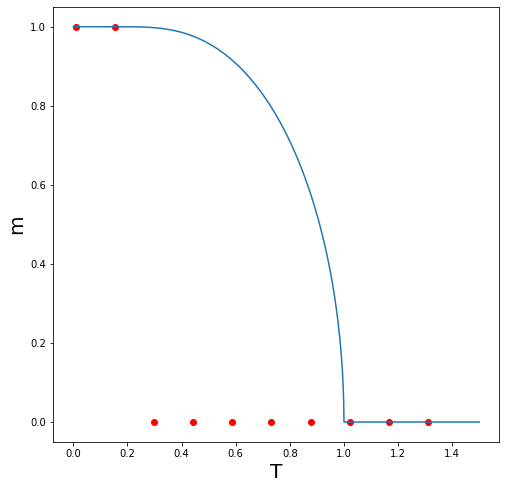

In [4]:
default_solve_args = {
    # 調整すべきパラメータ
    "a_mesh_num": 1,
    "T_mesh_num": 10,
    "mq_mesh_num": 20,
    "delta": pow(10, -3),
    
    # 範囲系
    "a_min": 0,
    "a_max": 0.3,
    "T_min": 0.01,
    "T_max": 1.31,
    "m_min": -1,
    "m_max": 1,
    "q_min": 0,
    "q_max": 1,
    
    "func_1": func_f,
    "func_2": func_g,
    
    # デバッグ用(1にしたら色々出力される)
    "debug": 0,
}

solve_a_0_and_plot(default_solve_args)

# 実行時間: 約5s
# メッシュが荒すぎる or 解の条件が厳しすぎる???

mq_mesh_num: 20 → 50


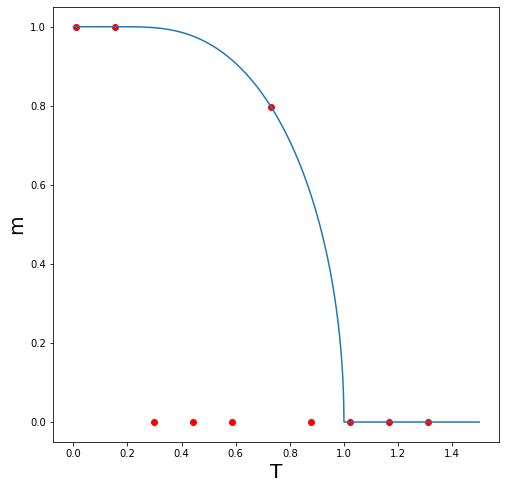

mq_mesh_num: 20 → 50
delta: 10^-3 → 10^-2


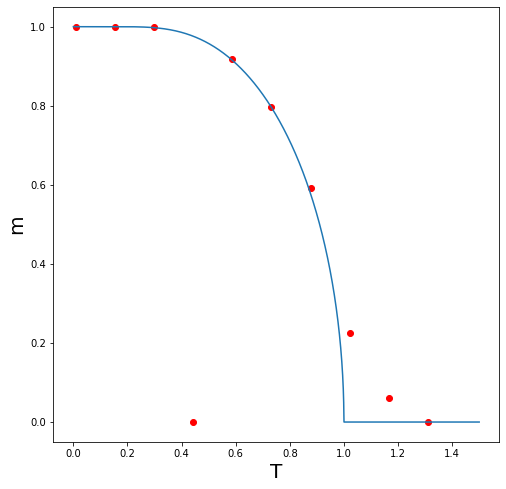

In [5]:
solve_args = default_solve_args.copy()

# m,qのメッシュを 20→50 に変更
solve_args["mq_mesh_num"] = 50

print("mq_mesh_num: 20 → 50")
solve_a_0_and_plot(solve_args)



# mqメッシュを50にまで上げてもゼロ解ばっかりなので、
# pow(10, -3)は解の条件として厳しすぎ感がある

# 解の条件をpow(10,-3) → pow(10, -2) に変更
solve_args["delta"] = pow(10, -2)
print("mq_mesh_num: 20 → 50")
print("delta: 10^-3 → 10^-2")
solve_a_0_and_plot(solve_args)

mq_mesh_num: 20 → 100
delta: 10^-3 → 10^-2


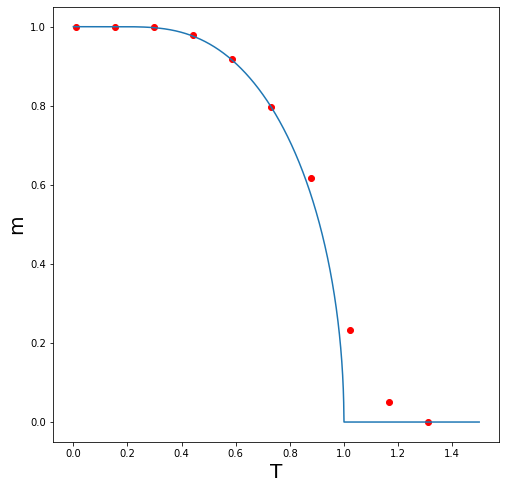

mq_mesh_num: 20 → 50
delta: 10^-3 → 10^-1


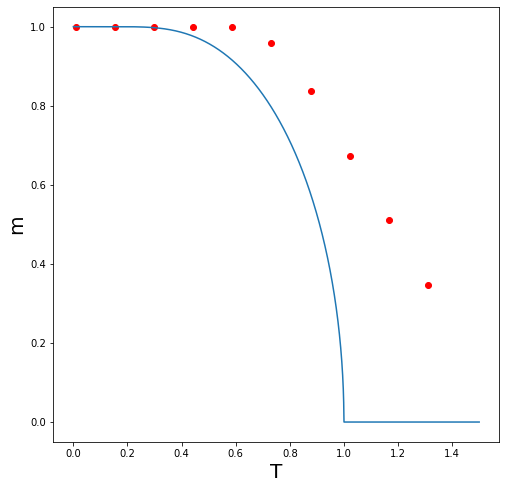

In [6]:
solve_args = default_solve_args.copy()

# いい感じになってきたが、まだゼロ解がある
# なので、mqメッシュを100まであげる
solve_args["mq_mesh_num"] = 100
solve_args["delta"] = pow(10, -2)

print("mq_mesh_num: 20 → 100")
print("delta: 10^-3 → 10^-2")
solve_a_0_and_plot(solve_args)


# 流石にpow(10,-1)はやりすぎだと思うけど、一応実験
solve_args["mq_mesh_num"] = 50
solve_args["delta"] = pow(10, -1)
print("mq_mesh_num: 20 → 50")
print("delta: 10^-3 → 10^-1")
solve_a_0_and_plot(solve_args)

mq_mesh_num: 20 → 100
delta: 10^-3 → 10^-2
T_mesh_num: 10 → 30


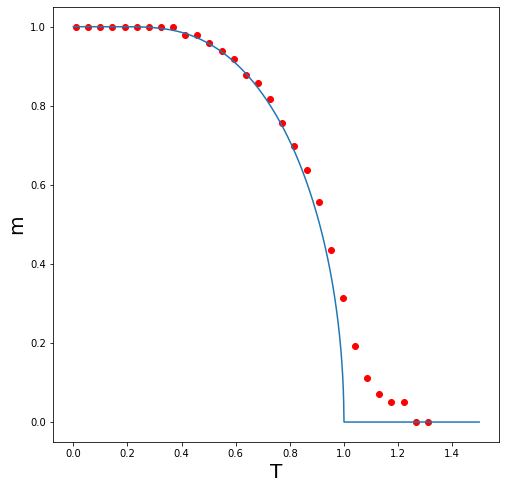

In [7]:
solve_args = default_solve_args.copy()

# mqメッシュ, 解の条件(delta)はこれで良さそうなので、
# プロット数を増やしてみる (これで計算時間= 5s * (5**2) * 3 = 約375s なのでだいぶ限界)
solve_args["mq_mesh_num"] = 100
solve_args["delta"] = pow(10, -2)
solve_args["T_mesh_num"] = 30

print("mq_mesh_num: 20 → 100")
print("delta: 10^-3 → 10^-2")
print("T_mesh_num: 10 → 30")

solve_a_0_and_plot(solve_args)

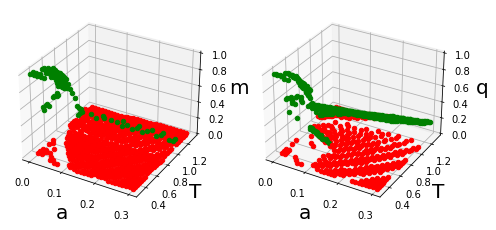

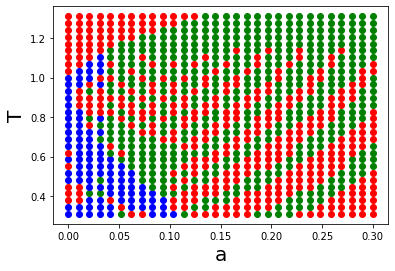

In [13]:
def plot_scatter(_ax, result_a_1, result_t_1, result_z_1, debug=False):
    for i in range(len(result_a_1)):
        if debug:
            print(result_a_1[i], result_t_1[i], result_z_1[i])
        _ax.scatter(result_a_1[i], result_t_1[i], result_z_1[i], color = "red" if result_z_1[i]<0.1 else "green")


# csv 読み出し
import matplotlib.pyplot as plt
result_arr = np.loadtxt("./result0207.csv", delimiter=",")

result_a = result_arr[:, 0]
result_t = result_arr[:, 1]
result_m = result_arr[:, 2]
result_q = result_arr[:, 3]

# プロット
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(121, projection='3d', zlim=(0, 1.0))

ax.set_xlabel("a", size = 20)
ax.set_ylabel("T", size = 20)
ax.set_zlabel("m", size = 20)

plot_scatter(ax, result_a, result_t, result_m)

# csv 読み出し
ax_2 = fig.add_subplot(122, projection='3d', zlim=(0, 1.0))

ax_2.set_xlabel("a", size = 20)
ax_2.set_ylabel("T", size = 20)
ax_2.set_zlabel("q", size = 20)

plot_scatter(ax_2, result_a, result_t, result_q)



fig = plt.figure()
ax_3 = fig.add_subplot(111)

ax_3.set_xlabel("a", size = 20)
ax_3.set_ylabel("T", size = 20)

for i in range(len(result_a)):
    color = "red" 
    if result_m[i] > 0.05 and result_q[i] > 0.05:
        color = "blue"
    elif result_q[i] > 0.05:
        color = "green"
    ax_3.scatter(result_a[i], result_t[i], color=color)


plt.show()